#Imports

In [0]:
import numpy as np
from numpy import genfromtxt

import scipy.io

from matplotlib import pyplot as plt

import keras
from keras.models import model_from_json
from keras.models import clone_model
from keras.models import Sequential
from keras.layers import *

import tensorflow as tf

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#Get data
This snipet connects to your drive where we assume the data is stored

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##-Load data
Here we read the data from Google Drive and we create folds for cross validation

In [300]:
my_data = genfromtxt('/content/drive/My Drive/data.csv', delimiter=',')

#Randomize and save a 10% of the date for test
np.random.shuffle(my_data)

X_test = my_data[0:int(my_data.shape[0] * 0.1), 1:361]
Y_test = my_data[0:int(my_data.shape[0] * 0.1), 0]

while unique_labels(Y_test).size != 7:
  np.random.shuffle(my_data)

  X_test = my_data[0:int(my_data.shape[0] * 0.1), 1:361]
  Y_test = my_data[0:int(my_data.shape[0] * 0.1), 0]
  
print(Y_test)

X_train = my_data[int(my_data.shape[0] * 0.1) + 1:, 1:361]
Y_train = my_data[int(my_data.shape[0] * 0.1) + 1:, 0]

#Generate folds for the training partition
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 69)
skf.get_n_splits(X_train, Y_train)



[1. 4. 1. 2. 5. 1. 2. 4. 1. 2. 2. 1. 2. 1. 1. 1. 5. 1. 5. 1. 2. 1. 1. 2.
 2. 1. 2. 5. 0. 4. 2. 2. 5. 1. 5. 2. 2. 0. 1. 0. 2. 1. 6. 2. 3. 5. 2. 1.
 4. 2. 2. 3. 1. 5. 1. 3. 2. 2. 5. 1. 1. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2. 3.
 2. 0. 5.]


5

#Neural Network 

##-Model definition

In [0]:



model = keras.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation=None),
    keras.layers.Dropout(0.5),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(50, activation=None),
    keras.layers.Dropout(0.5),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(7, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


##-Model training
We use a cross validation algorithm in order to avoid overfitting

In [302]:
best_err = 100.0
best_model = None

for train_index, test_index in skf.split(X_train, Y_train):
  #Get folds
  X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
  Y_train_fold, Y_test_fold = Y_train[train_index], Y_train[test_index]

  #Train with the folds
  model.fit(X_train_fold, Y_train_fold, epochs=100, verbose = 0)
  
  #Get accuracy
  score = model.evaluate(X_test_fold,Y_test_fold,verbose=0)
  err = (1-score[1]) * 100
  
  if err < best_err:
    best_model = model.get_weights()
    best_err = err

print('best error train rate: %f %%' % ( best_err ))
  

best error train rate: 0.000000 %


##-Test the best model obtained
Use the test partition to evaluate our model

In [303]:
#Test the best model got by far
model.set_weights(best_model) 
score = model.evaluate(X_test,Y_test)

print('error rate: %f %%' % ( (1-score[1]) * 100))

75/75 [==============================] - 0s 161us/step
error rate: 1.333333 %


###Some minnor info about the model trained

In [304]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_22 (Batc (None, 360)               1440      
_________________________________________________________________
dense_64 (Dense)             (None, 100)               36100     
_________________________________________________________________
dropout_43 (Dropout)         (None, 100)               0         
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_44 (Dropout)         (None, 50)                0         
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 50)                0         
__________

#Save the model to disk

In [2]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

NameError: ignored

#Load a model from disk
Example of how to load an already trained neural network from disk

In [306]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

print("Loaded model from disk")

Loaded model from disk


##Check model error with the test partition

In [307]:
loaded_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

score = loaded_model.evaluate(X_test,Y_test,verbose=0)

print('error rate: %f %%' % ( (1-score[1]) * 100))

error rate: 1.333333 %


#Metrics
##-Function to draw a confusion matrix

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


##-Considered classes

In [0]:
class_names = ["Dribbling", "Pass-Left", "Pass-Right", "Running", "Shot-Left", "Shot-Right", "Walking"]

##Draw normalized confusion matrix

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.95238095 0.04761905 0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


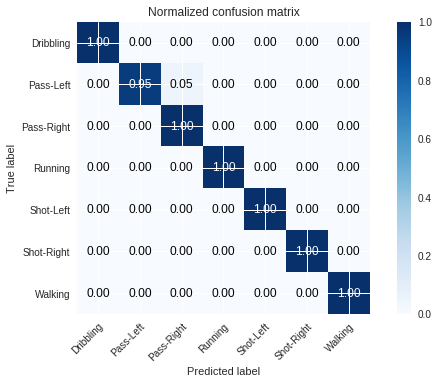

In [310]:
Y_prob = loaded_model.predict(X_test)
Y_classes = Y_prob.argmax(axis=-1)

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, Y_classes, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()